# TVB only simulation (but using tvb-multiscale)

## Step-by-step learn how to perform a TVB only simulation 

## Reduced Wong-Wang mean field model

For every region node $n\prime$ modelled as a mean-field node in TVB:

(Post)Synaptic gating dynamics (i.e., proportion of synapse channels open at any given time):

$\dot{S_{n\prime}}^{(E)} = - \frac{1}{\tau_E}{S_{n\prime}}^{(E)}(t) + (1-{S_{n\prime}}^{(E)}(t))\gamma_{E} {R_{n\prime}}^{(E)}(t)$

$\dot{S_{n\prime}}^{(I)} = - \frac{1}{\tau_I}{S_{n\prime}}^{(I)}(t) + \gamma_I{R_{n\prime}}^{(I)}(t)$

where we bound ${S_{n\prime}}^{(E/I)}(t) \in $ [0.0, 1.0], 

and $ {R_{n\prime}}^{(E/I)}(t) $ is the postsynaptic firing rate given by:

$ {R_{n\prime}}^{(E/I)}(t) = H({I_{syn_{n\prime}}}^{(E/I)}(t), a_{(E/I)}, b_{(E/I)}, d_{(E/I)}) $

where

$ H({I_{syn_{n\prime}}}^{(E/I)}(t),  a_{(E/I)}, b_{(E/I)}, d_{(E/I)}) = \frac{a_{(E/I)}{I_{syn_{n\prime}}}^{(E/I)}(t)-b_{(E/I)}}{1-e^{-d_{(E/I)}(a_{(E/I)}{I_{syn_{n\prime}}}^{(E/I)}(t)-b_{(E/I)})}}$ 

is a sigmoidal activation function of the input presynaptic current.

The total input presynaptic current to excitatory populations is given by: 

$ {I_{syn_{n\prime}}}^{(E)}(t) = W_EI_o + w_+J_{NMDA}{S_{n\prime}}^{(E)}(t) - J_{{n\prime}}{S_{n\prime}}^{(I)}(t) + GJ_{NMDA}\sum_{{m\prime}\neq {n\prime}}C_{{m\prime}{n\prime}}S_{m\prime}^{(E)}(t-\tau_{{m\prime}{n\prime}})$

and to inhibitory ones:

$ {I_{syn_{n\prime}}}^{(I)}(t) = W_II_o + J_{NMDA}{S_{n\prime}}^{(E)}(t) - {S_{n\prime}}^{(I)}(t) +  \lambda GJ_{NMDA}\sum_{{m\prime}\neq {n\prime}}C_{{m\prime}{n\prime}}S_{m\prime}^{(E)}(t-\tau_{{m\prime}{n\prime}})$

where 
$\lambda  \in$[0, 1] for scaling feedforward inhibition.

TVB connectivity weights $C_{{m\prime}{n\prime}}$ are scaled per "region"

## Reduced Wong-Wang mean field model

## Parameters following Ponce-Alvarez et al 2014:

- structural TVB connectivity weights $C_{{m\prime}{n\prime}}$ (${m\prime}->{n\prime}$)
- structural TVB connectivity delays $\tau_{{m\prime}{n\prime}}$  (${m\prime}->{n\prime}$)
- global structural brain connectivity coupling constant $G$
- overall effective external input current $I_o = 0.382nA$ 
- excitatory synaptic coupling $J_{NDMA} = 0.15nA$ 
- local feedback inhibitory synaptic coupling $J_{i} = 1.0nA$ 
- local excitatory recurrence $w_+ = 1.4$
- excitatory kinetic parameter $\gamma_E = 0.641 s$
- inhibitory kinetic parameter $\gamma_I = 1.0 s$
- excitatory (NMDA) time constant $\tau_E = \tau_{NMDA}=100ms$ 
- inhibitory (GABA) time constant $\tau_I = \tau_{GABA}=10ms$ 
- excitatory pool scaling constant $W_E = 1.0$
- inhibitory pool scaling constant $W_I = 0.7$
- excitatory sigmoidal functions parameters $a_{E} = 310nC^{-1}$, $b_{E} = 125Hz$, $d_{E} = 0.16s$
- inhibitory sigmoidal functions parameters $a_{I} = 615nC^{-1}$, $b_{I} = 177Hz$, $d_{I} = 0.087s$
- $\lambda = 1$, allowing for feedforward inhibition


# WORKFLOW:

In [1]:
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *

work_path = os.getcwd()
outputs_path = os.path.join(work_path, "outputs/RedWongWang_TVB_only")
config = Config(output_base=outputs_path)

config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)


Connectome used for simulations


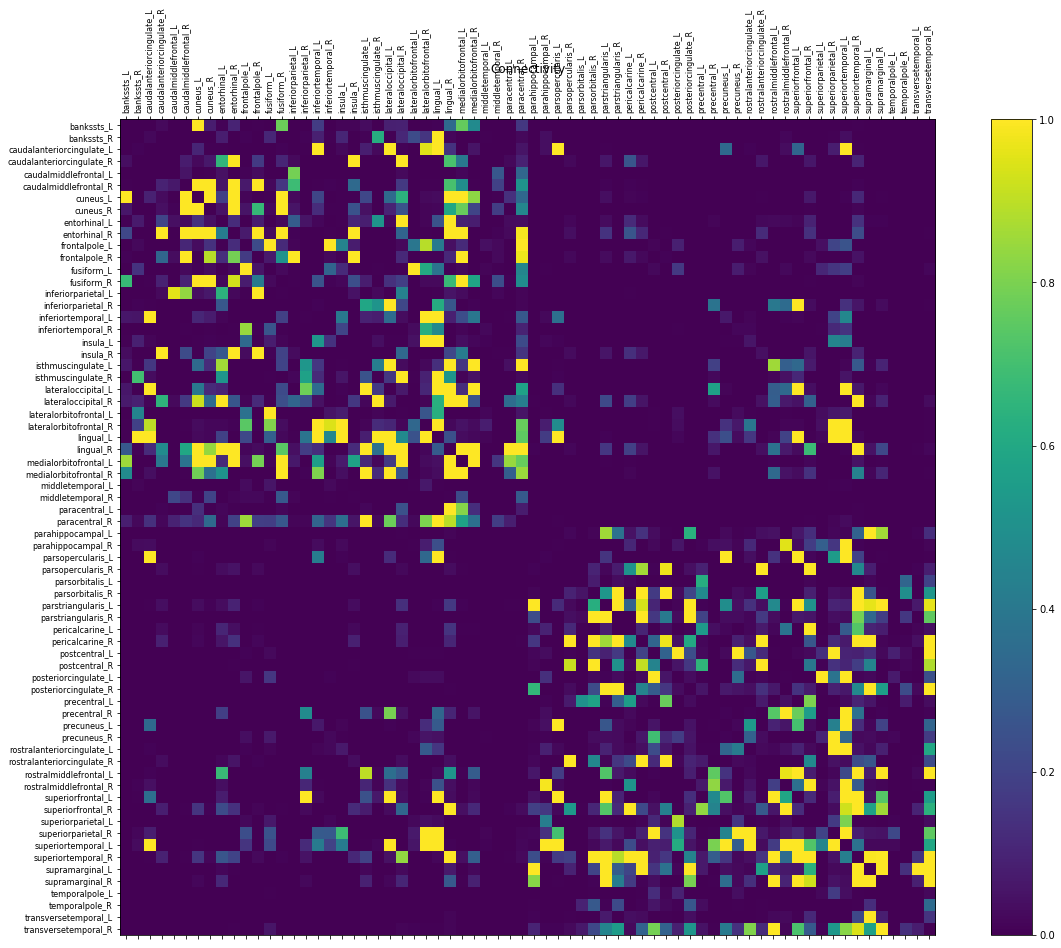

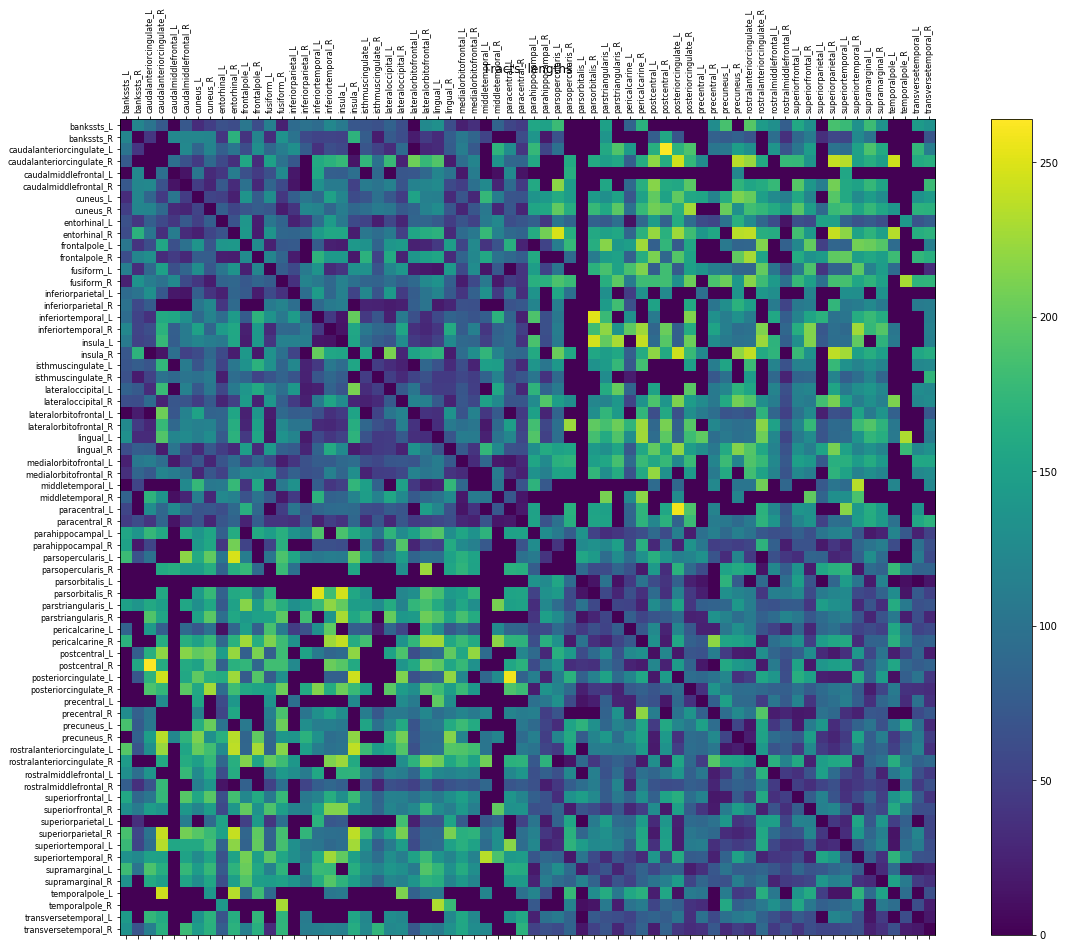

In [2]:
from tvb.simulator.models.reduced_wong_wang_exc_io_inh_i import ReducedWongWangExcIOInhI
from tvb_multiscale.core.tvb.simulator_builder import SimulatorBuilder


# # ----------------------1. Build a TVB simulator (model, integrator, monitors...)----------------------------------
# # Simulator builder is a helping tool of tvb-multiscale.core package to configure a TVB simulation
# # Simulator builder uses the CoSimulator class used for multiscale simulations, 
# # however, in the absence of any interface to NEST, it will just configure and perform a TVB only simulation.
# simulator_builder = SimulatorBuilder()
# simulator_builder.connectivity = config.DEFAULT_CONNECTIVITY_ZIP
# simulator_builder.model = ReducedWongWangExcIOInhI
# model_params = {"G": np.array([20.0, ]), "J_i": np.array([1.0, ]), "lamda": np.array([0.0, ])}
# simulator = simulator_builder.build(**model_params)


# To see what the simulator_builder does, uncomment the code below:
# All the steps below would be identical, if tvb.simulator.simulator.Simulator class was used instead

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

from tvb.simulator.cosimulator import CoSimulator
from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG
    
# Load connectivity
connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)
# Normalize connectivity weights
connectivity.weights = connectivity.scaled_weights(mode="region")
connectivity.weights /= np.percentile(connectivity.weights, 95)
connectivity.weights[connectivity.weights>1.0] = 1.0
connectivity.configure()

# Create a TVB simulator and set all desired inputs
# (connectivity, model, integrator, monitors, etc)
# We choose all defaults in this example
simulator = CoSimulator()
simulator.model = ReducedWongWangExcIOInhI()
simulator.model.G = np.array([20.0, ])     # Global cloupling scaling
simulator.model.J_i = np.array([1.0, ])   # Feedback inhibition
simulator.model.lamda = np.array([0.0, ]) # Feedforward inhibition

simulator.connectivity = connectivity

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([0.001])

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, ) # Bold, EEG

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

print("\nConnectome used for simulations")
plotter.plot_tvb_connectivity(simulator.connectivity);



## 2. Configure simulator, simulate, gather results

In [3]:
# Configure the simulator with the TVB-NEST interface...
simulator.configure()
# ...and simulate!
t = time.time()
simulation_length=110.0
transient = 10.0 # simulation_length/11 to be removed later on for computations
results = simulator.run(simulation_length=simulation_length)
print("\nSimulated in %f secs!" % (time.time() - t))


Simulated in 1.233122 secs!


## 3. Plot results and write them to HDF5 files

In [4]:
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in nest_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
# plot_write_results(results, simulator, populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [5]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
        data=results[0][1], time=results[0][0] - results[0][0][0],
        connectivity=simulator.connectivity,
        labels_ordering=["Time", "State Variable", "Region", "Neurons"],
        labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                           "Region": simulator.connectivity.region_labels.tolist()},
        sample_period=simulator.integrator.dt)
source_ts.configure()

t = source_ts.time
    
# Write to file
if writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                    connectivity=source_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
source_ts



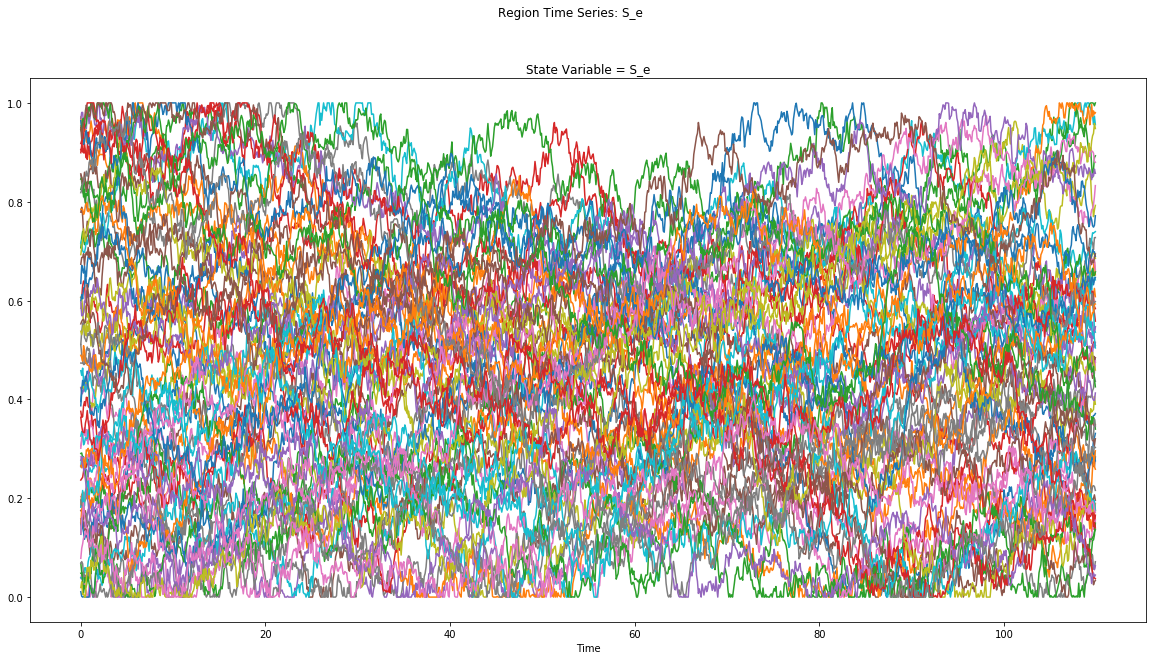

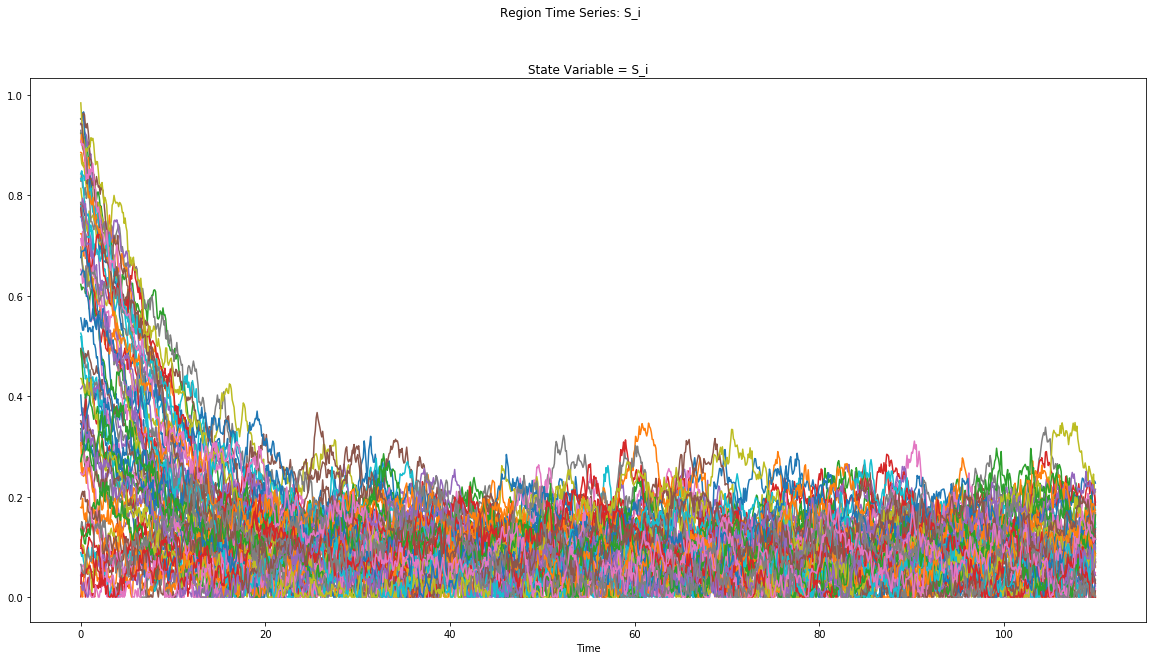

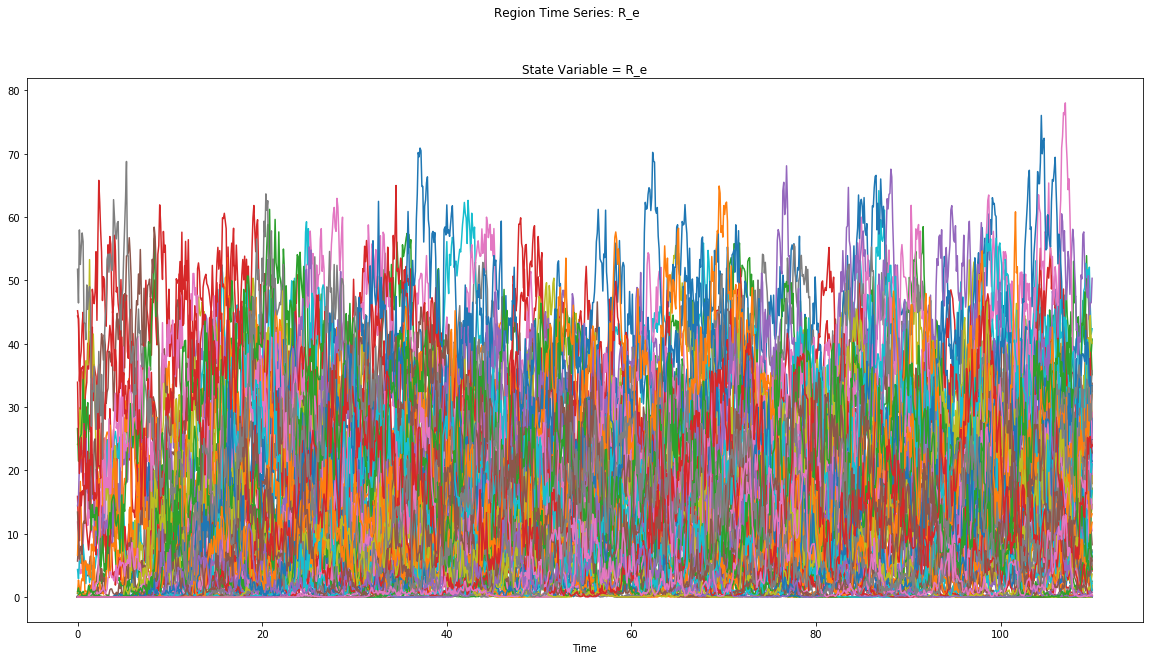

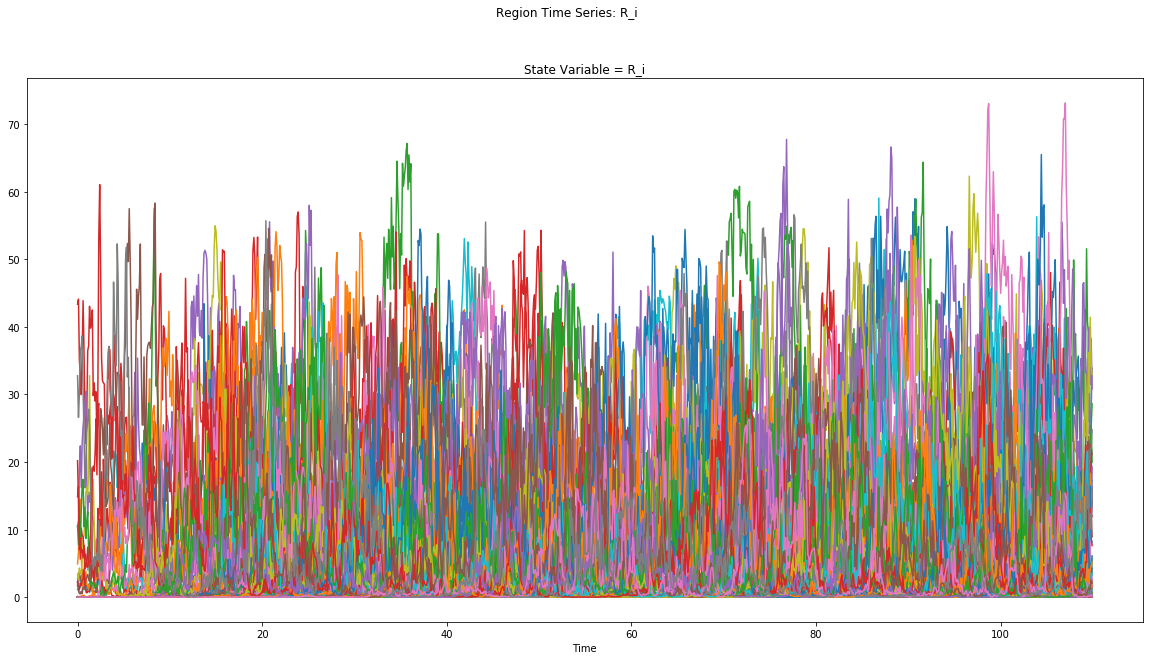

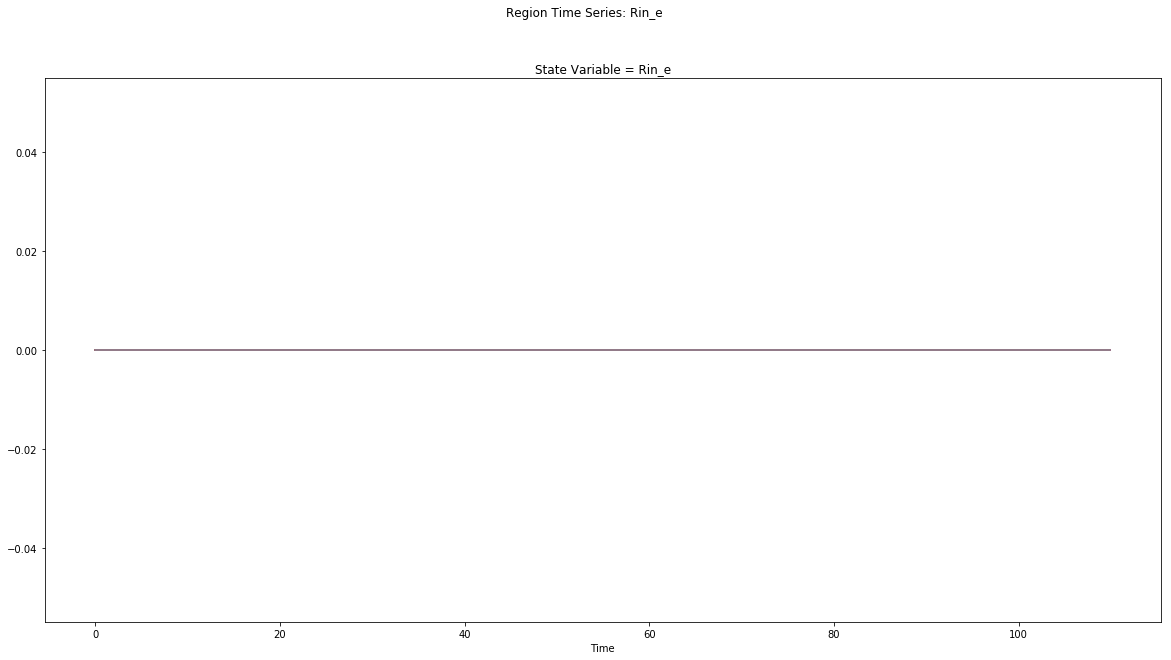

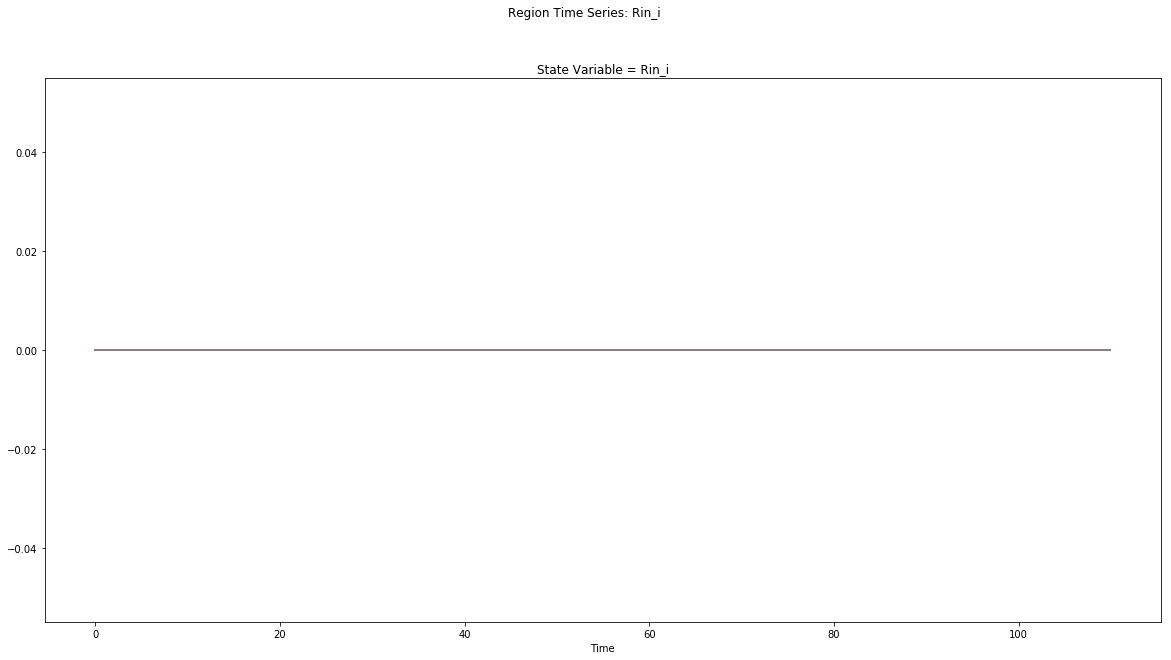

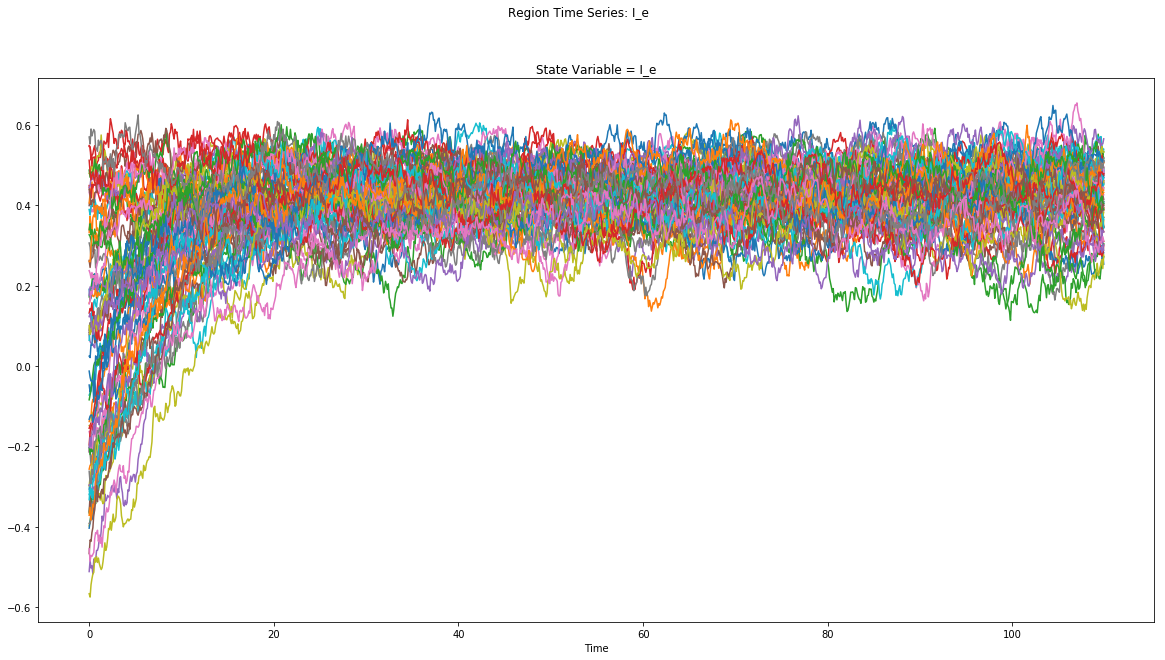

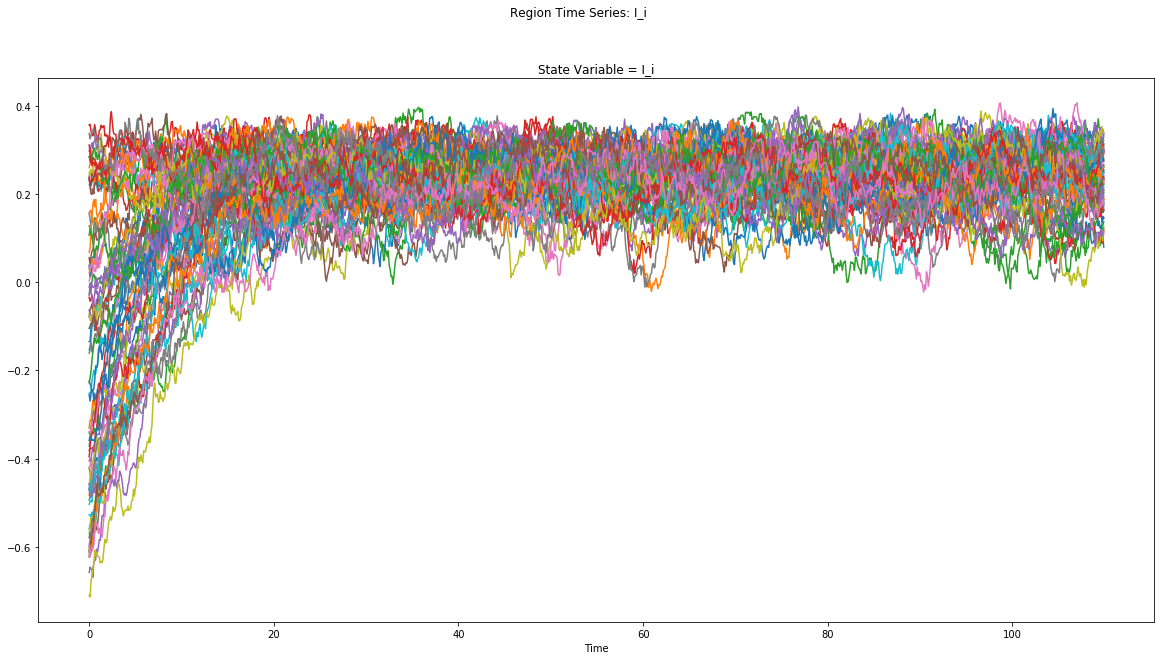

In [6]:
# Plot TVB time series
source_ts.plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

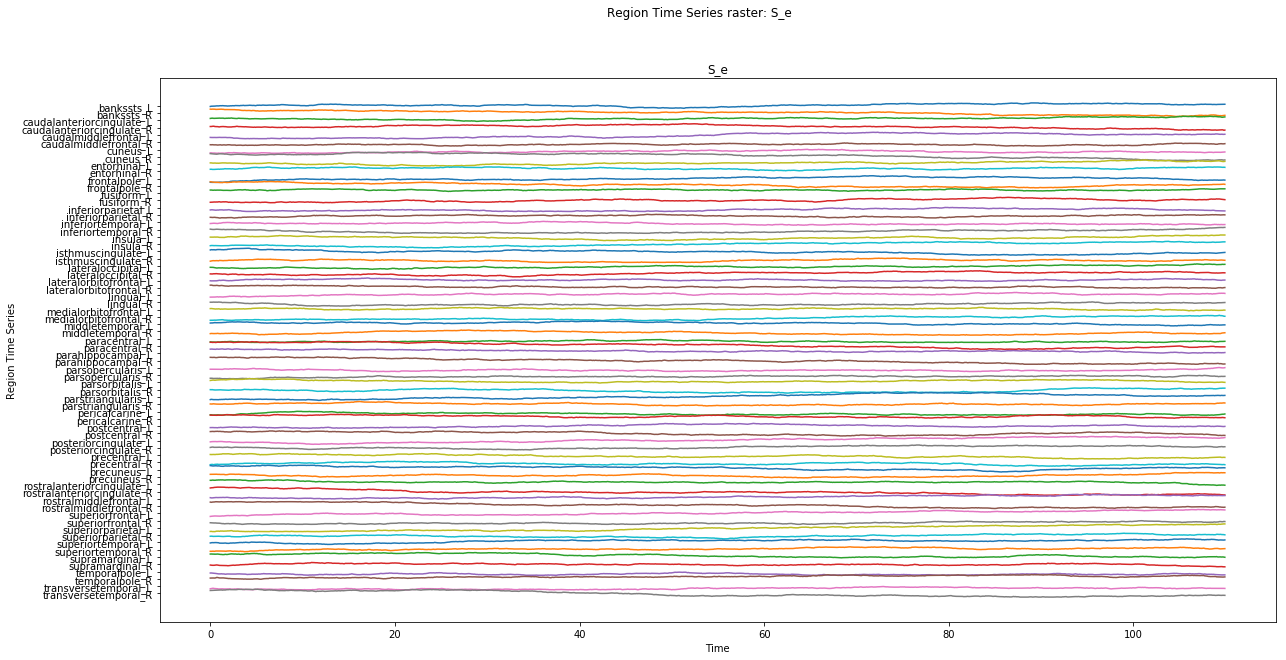

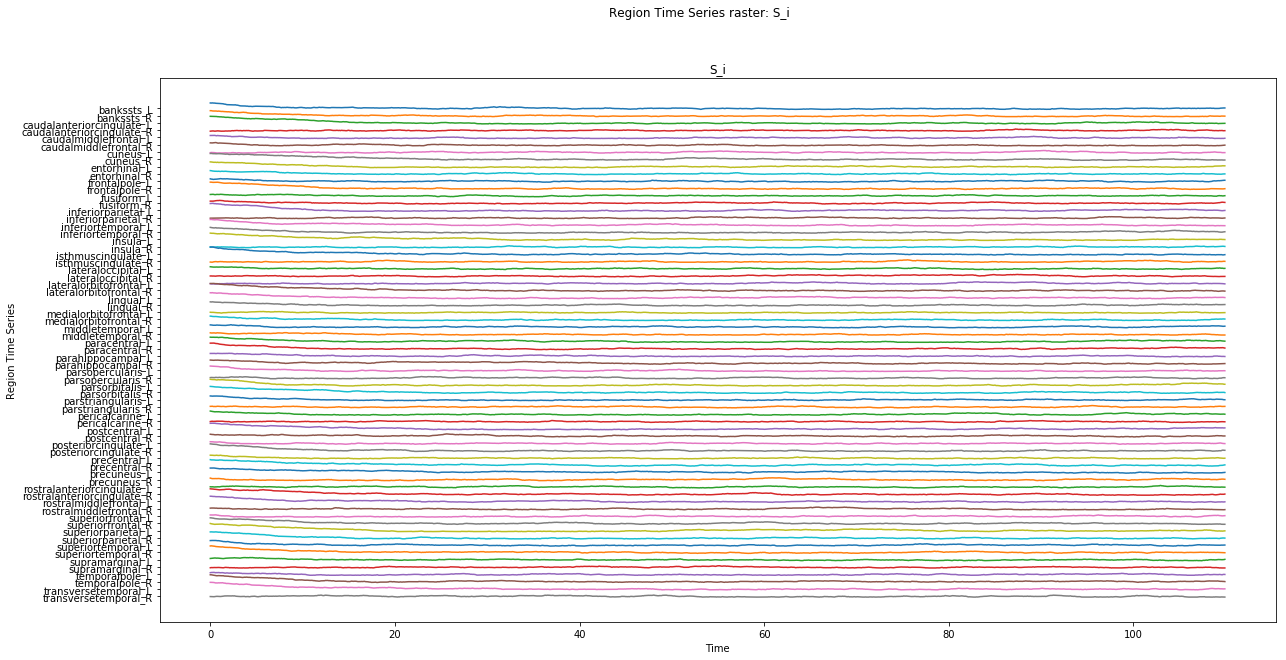

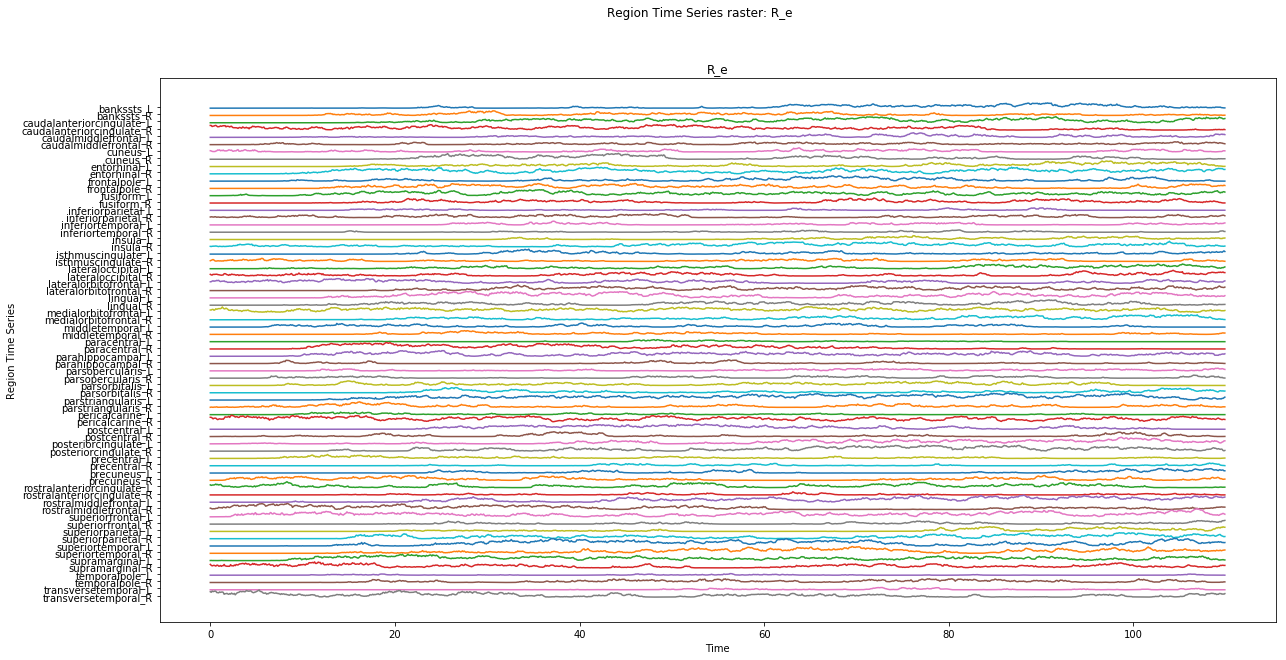

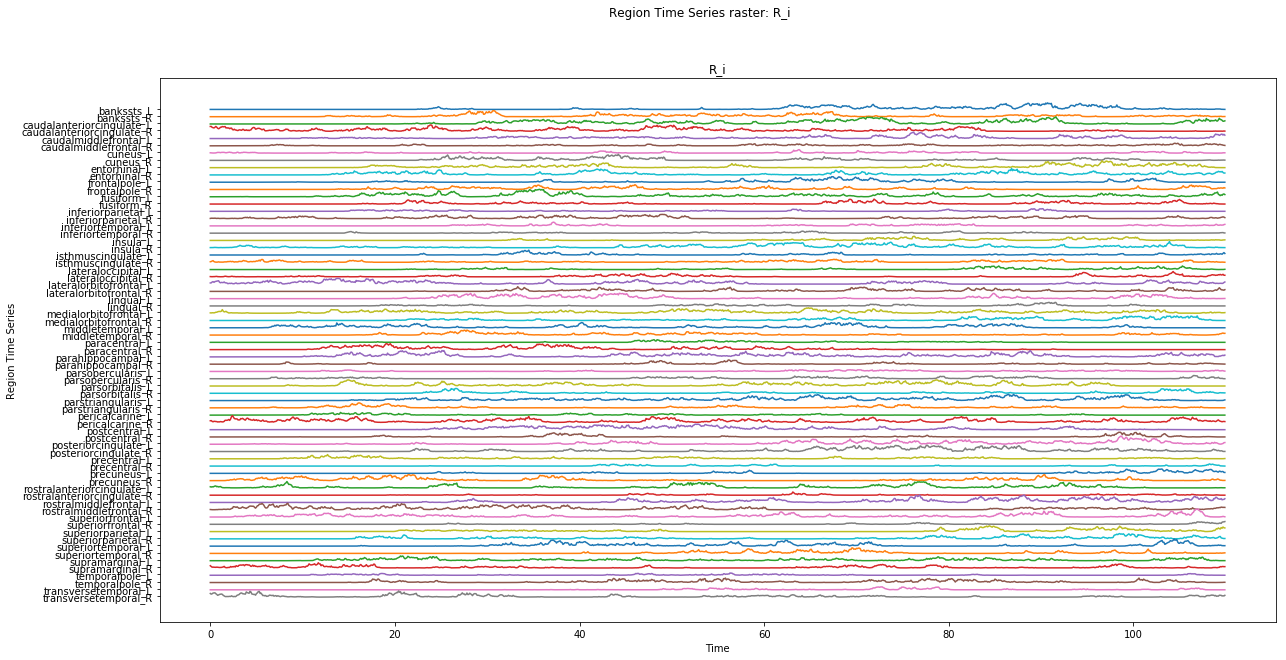

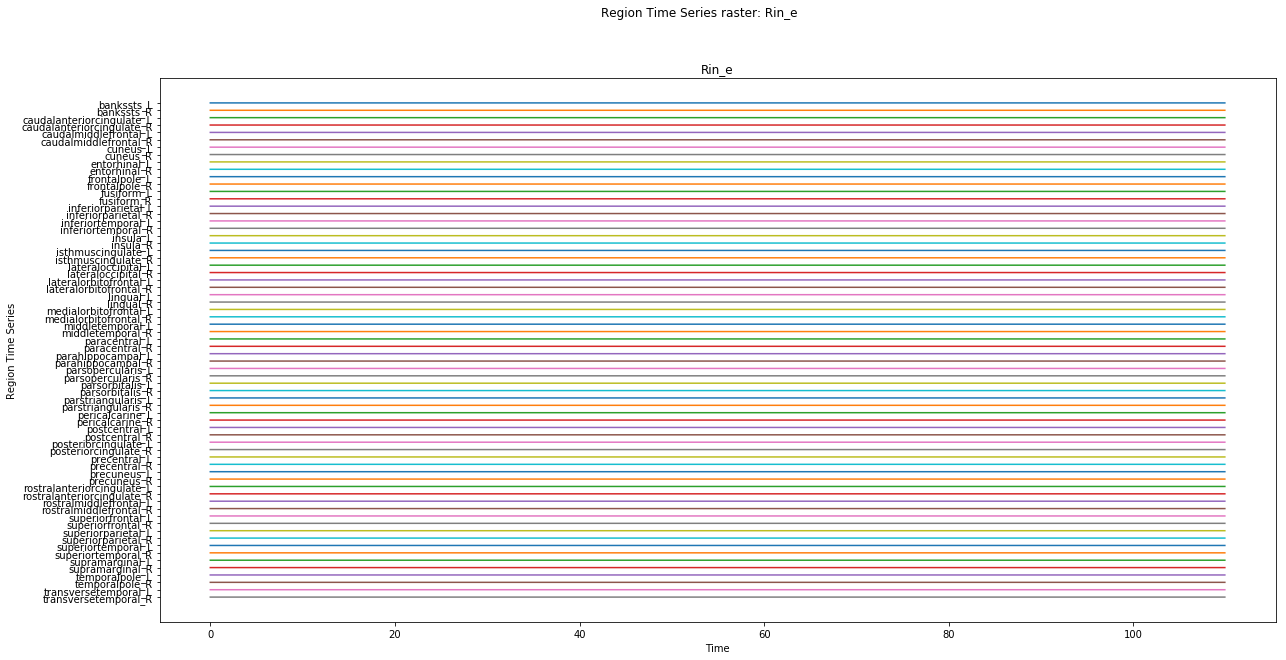

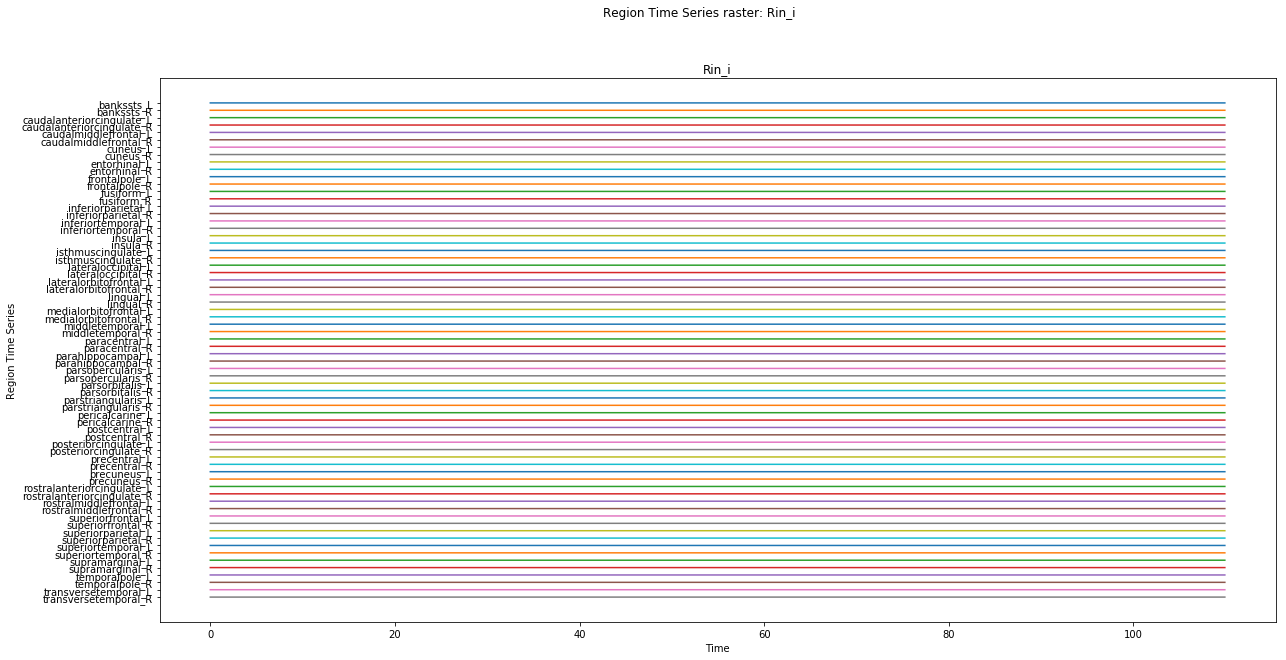

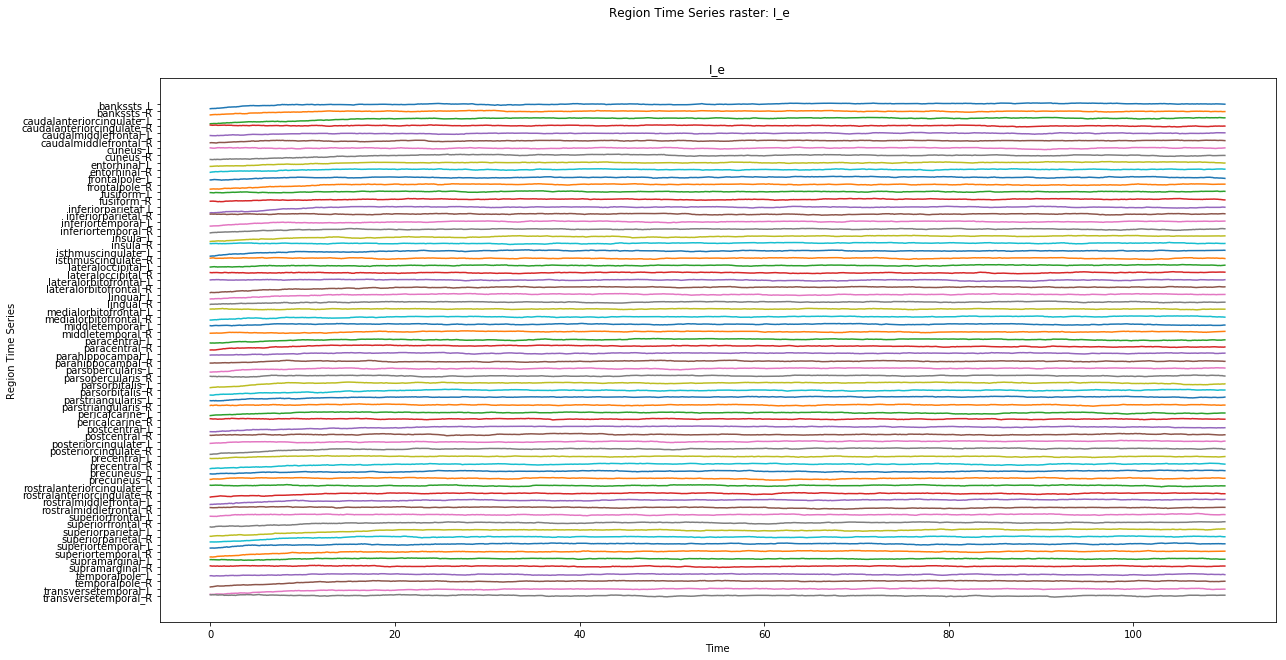

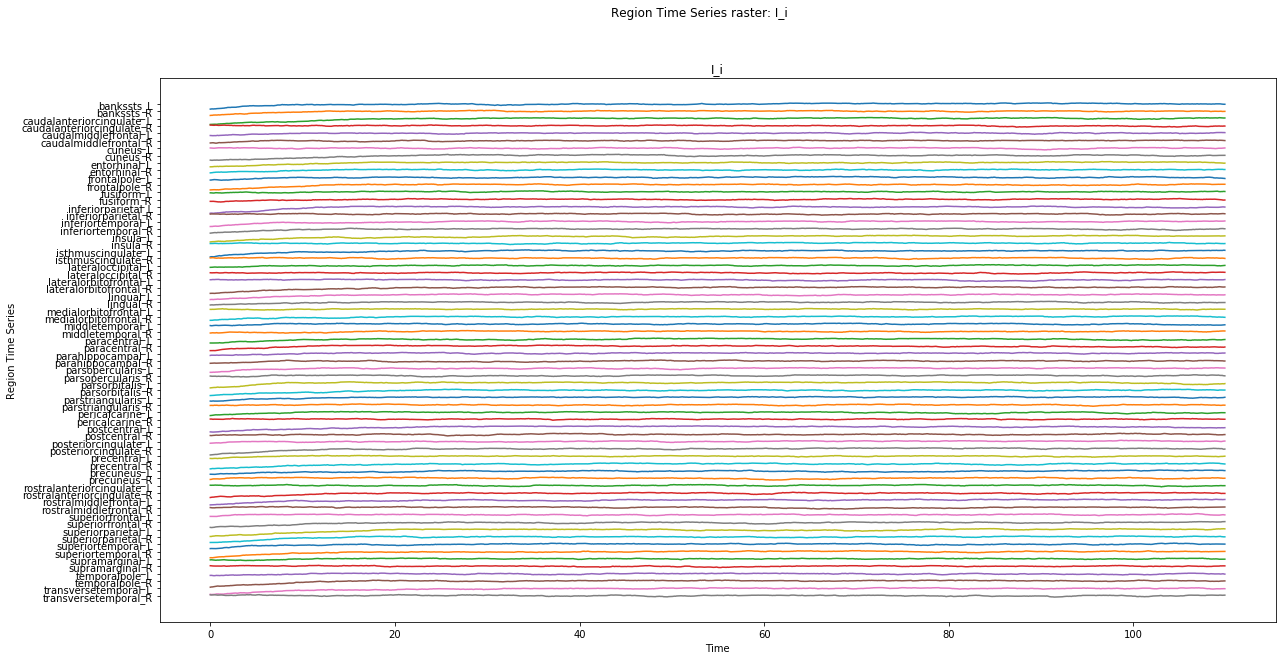

In [7]:
# TVB time series raster plot:
if source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts.plot_raster(plotter_config=plotter.config, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
                          figsize=FIGSIZE);

# References

1 Sanz Leon P, Knock SA, Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics 7:10. doi: 10.3389/fninf.2013.00010 <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK (2013).  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>
  
3 Deco Gustavo, Ponce-Alvarez Adrian, Patric Hagmann, <br>
  Gian Luca Romani, Dante Mantini,and Maurizio Corbetta. <br>
  How local Excitation-Inhibition Ratio Impacts the Whole Brain Dynamics <br>
  The Journal of Neuroscience 34(23), 7886-7898, 2014.<br>
  
4 Deco Gustavo, Ponce-Alvarez Adrian, Dante Mantini,<br>
  Gian Luca Romani, Patric Hagmann, and Maurizio Corbetta. <br>
  How local Excitation-Inhibition Ratio Impacts the Whole Brain Dynamics <br>
  The Journal of Neuroscience 33(27), 11239-11252, 2013.<br>
